<a href="https://colab.research.google.com/github/bleamer/eva5/blob/master/w11-SuperConvergence/w11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
current_path = '/content/drive/My Drive/eva5/w11-SuperConvergence/' 
os.chdir(current_path)

In [4]:
!ls

Accuracies.png	__init__.py  output    README.md  utils
dataset		model	     postproc  req.txt


In [5]:
!pip install -q -r req.txt

In [6]:
import torch                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
import torchvision
import torchvision.transforms as transforms

from model.train import train
from model.cnn import Net
from model.resnet import ResNet18
from model.rnet import ResModel
from model.eval import val
from model.utils import cuda_init, cross_entropy_loss, sgd_optimizer, model_summary
from utils import CyclicLR

from dataset.dataset import DS_Cifar10
from dataset.download import download_cifar10

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from model.tools import LRFinder


In [7]:
from pathlib import Path
Path(current_path+'/output').mkdir(parents=True, exist_ok=True)


### Init Device

In [8]:
RAND_VAL = 42

TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
NUM_WORKER = 64

In [9]:
cuda, dev = cuda_init(RAND_VAL)
print(cuda, dev)

True cuda


In [10]:
!nvidia-smi --query-gpu=timestamp,gpu_name,utilization.gpu,utilization.memory --format=csv

timestamp, name, utilization.gpu [%], utilization.memory [%]
2020/10/10 20:20:21.982, Tesla T4, 0 %, 0 %


### Fetch and Check the data

In [11]:
hflip = 0.1
vflip = 0.0
rotation = 0.0
cutout=0.1
cutout_dimen = (8,8)
pad_size = 4
padding=(40, 40)
crop_prob = 0.1
crop=(32, 32)

In [12]:
DS = DS_Cifar10(path='/tmp', hflip = hflip, vflip = vflip,rotation = rotation,
                cutout=cutout, cutout_dimen=cutout_dimen, 
                padding=padding, crop = crop, crop_prob = crop_prob)
Classes = DS.classes

path /tmp
Files already downloaded and verified
(40, 40) 40 40
Transformations
{'path': '/tmp', 'hflip': 0.1, 'vflip': 0.0, 'rotation': 0.0, 'cutout': 0.1, 'cutout_dimen': (8, 8), 'padding': (40, 40), 'crop': (32, 32), 'crop_prob': 0.1}
path /tmp
Files already downloaded and verified
(40, 40) 40 40
Transformations
{'train': False, 'path': '/tmp', 'hflip': 0.1, 'vflip': 0.0, 'rotation': 0.0, 'cutout': 0.1, 'cutout_dimen': (8, 8), 'padding': (40, 40), 'crop': (32, 32), 'crop_prob': 0.1}
path /tmp
Files already downloaded and verified


### Data Loaders

In [13]:
train_loader = DS.loader(batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKER, cuda=cuda)
test_loader = DS.loader(train = False, batch_size=TEST_BATCH_SIZE, num_workers=NUM_WORKER, cuda=cuda)

{'batch_size': 512, 'num_workers': 64, 'cuda': True}
train True
{'train': False, 'batch_size': 512, 'num_workers': 64, 'cuda': True}
train False


In [14]:
DROPOUT = 0.1
# model = Net(DROPOUT).to(dev)
model = ResModel().to(dev)

In [15]:
image_size = DS.image_size
model_summary(model, image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
         ResBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient


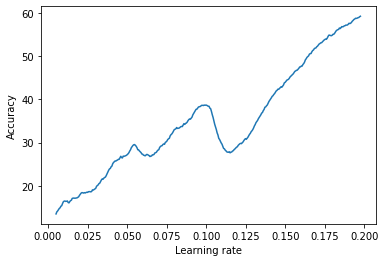

In [16]:
import torch.optim as optim

EPOCHS = 25
LEARNING_RATE = 0.01
MOMENTUM = 0.9
SAMPLE_COUNT = 25
START_LR = 1E-7
END_LR = .2
NUM_ITER = len(train_loader) * 4
LR_DECAY_FACTOR = 0.1
LR_DECAY_PATIENCE = 2

TARGET_ACCURACY = 91+1

criterion = cross_entropy_loss()  # Create loss function

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
lr_finder = LRFinder(model, optimizer, criterion, device=dev)
lr_finder.range_test(train_loader,start_lr=START_LR, end_lr=END_LR, num_iter=NUM_ITER, step_mode="linear")
lr_finder.plot_accuracy(log_lr=False)
lr_finder.reset()
best_lr= lr_finder.get_best_lr()

In [17]:
print('best learning from search', best_lr)
for param_group in optimizer.param_groups:
    print('optimizer current lr:', str(param_group['lr']))

best learning from search 0.02199497391304348
optimizer current lr: 0.01


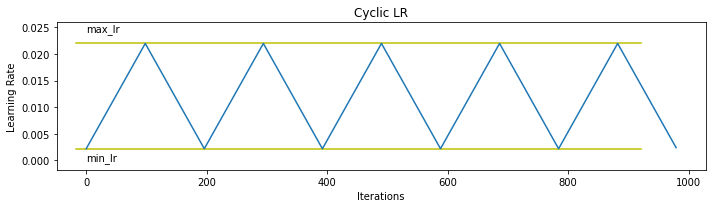

<Figure size 432x288 with 0 Axes>

In [18]:
clr = CyclicLR(best_lr, best_lr / 10, len(train_loader), len(train_loader) * 10)
clr.cyclic_lr(plot=True, save=True, path=current_path+'/output/clr.png')

In [19]:

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, OneCycleLR




losses = []
train_accuracies = []
accuracies = []
incorrect_samples = []
correct_samples = []


optimizer = optim.SGD(model.parameters(), lr= lr_finder.get_best_lr(), momentum=MOMENTUM)
for param_group in optimizer.param_groups:
    print('Starting Learning rate:',str(param_group['lr']))
# scheduler = StepLR(optimizer, step_size=10, gamma=0.3)
# scheduler = ReduceLROnPlateau(optimizer, factor=LR_DECAY_FACTOR, 
    #                           patience=LR_DECAY_PATIENCE, verbose=True, min_lr=MIN_LR
    # )

scheduler = OneCycleLR(
    optimizer, lr_finder.get_best_lr(), epochs=EPOCHS,
    steps_per_epoch=len(train_loader), pct_start=5/EPOCHS,
    div_factor=10, final_div_factor=1
)

for epoch in tqdm(range(1, EPOCHS + 1)):
    print(f'Epoch {epoch}:')
    train(model, train_loader, dev, optimizer, criterion, accuracy_hist = train_accuracies)

    val(
        model, test_loader, dev, criterion, losses, accuracies,
        correct_samples, incorrect_samples, SAMPLE_COUNT, epoch,EPOCHS
    )
    optimizer.step()
    scheduler.step(losses[-1])
    if accuracies[-1] > TARGET_ACCURACY:
      break

  0%|          | 0/25 [00:00<?, ?it/s]

Starting Learning rate: 0.02199497391304348
Epoch 1:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  4%|▍         | 1/25 [00:43<17:14, 43.11s/it]


Validation set: Average loss: 0.0027, Accuracy: 5344/10000 (53.44%)

Epoch 2:


  8%|▊         | 2/25 [01:26<16:32, 43.14s/it]


Validation set: Average loss: 0.0021, Accuracy: 6469/10000 (64.69%)

Epoch 3:


 12%|█▏        | 3/25 [02:09<15:48, 43.11s/it]


Validation set: Average loss: 0.0017, Accuracy: 7097/10000 (70.97%)

Epoch 4:


 16%|█▌        | 4/25 [02:52<15:04, 43.09s/it]


Validation set: Average loss: 0.0016, Accuracy: 7285/10000 (72.85%)

Epoch 5:


 20%|██        | 5/25 [03:35<14:22, 43.11s/it]


Validation set: Average loss: 0.0014, Accuracy: 7640/10000 (76.40%)

Epoch 6:


 24%|██▍       | 6/25 [04:19<13:41, 43.25s/it]


Validation set: Average loss: 0.0012, Accuracy: 7897/10000 (78.97%)

Epoch 7:


 28%|██▊       | 7/25 [05:02<12:56, 43.15s/it]


Validation set: Average loss: 0.0012, Accuracy: 8088/10000 (80.88%)

Epoch 8:


 32%|███▏      | 8/25 [05:45<12:13, 43.14s/it]


Validation set: Average loss: 0.0011, Accuracy: 8142/10000 (81.42%)

Epoch 9:


 36%|███▌      | 9/25 [06:28<11:29, 43.10s/it]


Validation set: Average loss: 0.0012, Accuracy: 8013/10000 (80.13%)

Epoch 10:


 40%|████      | 10/25 [07:11<10:48, 43.21s/it]


Validation set: Average loss: 0.0011, Accuracy: 8251/10000 (82.51%)

Epoch 11:


 44%|████▍     | 11/25 [07:55<10:06, 43.29s/it]


Validation set: Average loss: 0.0013, Accuracy: 8048/10000 (80.48%)

Epoch 12:


 48%|████▊     | 12/25 [08:39<09:25, 43.48s/it]


Validation set: Average loss: 0.0011, Accuracy: 8249/10000 (82.49%)

Epoch 13:


 52%|█████▏    | 13/25 [09:22<08:42, 43.54s/it]


Validation set: Average loss: 0.0010, Accuracy: 8372/10000 (83.72%)

Epoch 14:


 56%|█████▌    | 14/25 [10:06<07:58, 43.54s/it]


Validation set: Average loss: 0.0011, Accuracy: 8378/10000 (83.78%)

Epoch 15:


 60%|██████    | 15/25 [10:51<07:20, 44.01s/it]


Validation set: Average loss: 0.0011, Accuracy: 8426/10000 (84.26%)

Epoch 16:


 64%|██████▍   | 16/25 [11:34<06:34, 43.79s/it]


Validation set: Average loss: 0.0011, Accuracy: 8409/10000 (84.09%)

Epoch 17:


 68%|██████▊   | 17/25 [12:18<05:49, 43.66s/it]


Validation set: Average loss: 0.0011, Accuracy: 8502/10000 (85.02%)

Epoch 18:


 72%|███████▏  | 18/25 [13:01<05:04, 43.56s/it]


Validation set: Average loss: 0.0011, Accuracy: 8534/10000 (85.34%)

Epoch 19:


 76%|███████▌  | 19/25 [13:45<04:22, 43.73s/it]


Validation set: Average loss: 0.0010, Accuracy: 8560/10000 (85.60%)

Epoch 20:


 80%|████████  | 20/25 [14:28<03:38, 43.64s/it]


Validation set: Average loss: 0.0012, Accuracy: 8396/10000 (83.96%)

Epoch 21:


 84%|████████▍ | 21/25 [15:12<02:54, 43.57s/it]


Validation set: Average loss: 0.0011, Accuracy: 8539/10000 (85.39%)

Epoch 22:


 88%|████████▊ | 22/25 [15:55<02:10, 43.53s/it]


Validation set: Average loss: 0.0010, Accuracy: 8588/10000 (85.88%)

Epoch 23:


 92%|█████████▏| 23/25 [16:39<01:26, 43.46s/it]


Validation set: Average loss: 0.0011, Accuracy: 8538/10000 (85.38%)

Epoch 24:


 96%|█████████▌| 24/25 [17:22<00:43, 43.52s/it]


Validation set: Average loss: 0.0011, Accuracy: 8605/10000 (86.05%)

Epoch 25:


100%|██████████| 25/25 [18:22<00:00, 44.10s/it]


Validation set: Average loss: 0.0011, Accuracy: 8589/10000 (85.89%)



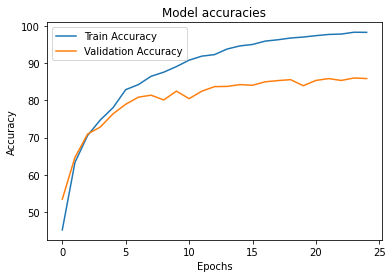

In [21]:
fig, ax = plt.subplots()
ax.plot(train_accuracies)
ax.plot(accuracies)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Model accuracies')
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.savefig('Accuracies.png')
plt.show()

In [22]:
total_params = sum(param.numel() for name, param in  model.named_parameters())


In [23]:
readme = f'''

# 11 - Super Convergence

## Learning Rate Finder and OneCycle LR strategy
 
This notebook implements CIFAR10 classification using ResNet NN architecture using PyTorch,
and uses GradCAM analysis for model explanation  to explain which layer of model was activated for the give image

* Here we use Data Augmentation strategies  and implement using [Albumentations](https://github.com/albumentations-team/albumentations) library and
* Used One Cycle Learing Rate strategy to train model following learning rate finder to find LR where rate of change of losses is minimun (max negative)

The results with using ResNet18 architecture with (2,2,2,2), that is, 4 residual blocks of size 2 each.
 
----
| Attribute | Value |
|:--- | :--- |
| Train Accuracy | {np.max(train_accuracies)} |
| Test Accuracy | {np.max(accuracies)} |
| Trained Parameter count   |{total_params} |
| Dropout | {DROPOUT} |
| Total Epochs | {EPOCHS} |
| Batch Size | {TRAIN_BATCH_SIZE}|
| LR using LRFinder | {lr_finder.get_best_lr():.4f}|


----
### Accuracies
![](Accuracies.png)

### Cyclic LR amplitudes
![](output/clr.png)

The model uses:
* 3x3 Convolution
* Batch Normalization
* Max Pooling
* 4 X Residual networks of size 2 

## Environment Setup
To run 

You can install dependencies using  
`$ pip install -r req.txt`

'''

with open('README.md', 'w') as f:
    f.write(readme)